Connecting to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Preparing the dataset (Kinematic)

In [2]:
import numpy as np
import json

# -----------------------------
# 1. LOAD DATA
# -----------------------------
DATA_DIR = "/content/drive/MyDrive/kinematic_dataset_final/stgcn_input/"

data_arr = np.load(DATA_DIR + "data.npy")       # (N, 9, T, V)
labels_arr = np.load(DATA_DIR + "labels.npy")   # (N,)

with open(DATA_DIR + "meta.json", 'r') as f:
    meta = json.load(f)

print("Loaded data:", data_arr.shape)
print("Loaded labels:", labels_arr.shape)
print("Meta keys:", meta.keys())

# -----------------------------
# 2. EXTRACT DIMENSIONS
# -----------------------------
N, C, T, V = data_arr.shape
print(f"N={N}, C={C}, T={T}, V={V}")

# -----------------------------
# 3. PREPARE LSTM INPUT FORMAT
# -----------------------------
# Convert (N, C, T, V) → (N, T, C*V)
X = data_arr.transpose(0, 2, 1, 3).reshape(N, T, C * V)

print("LSTM-ready X shape:", X.shape)  # Expected: (N, T, 9*V)


Loaded data: (932, 3, 100, 59)
Loaded labels: (932,)
Meta keys: dict_keys(['joint_names', 'edge_list', 'label2idx', 'target_frames', 'center_root', 'normalize'])
N=932, C=3, T=100, V=59
LSTM-ready X shape: (932, 100, 177)


Reshaping the dataset for LSTM


In [3]:
X = data_arr.transpose(0, 2, 1, 3).reshape(N, T, 3*V)


Adding motion features

In [4]:
import numpy as np

def add_motion_features_batch(X):
    """
    X shape: (N, 3, T, V)
    Returns: (N, 9, T, V)
    """
    N, C, T, V = X.shape
    assert C == 3, "Expected 3 channels (x,y,z) before motion features"

    X_new = np.zeros((N, 9, T, V), dtype=np.float32)

    for i in range(N):
        pos = X[i]                       # (3, T, V)

        # Velocity
        vel = np.zeros_like(pos)
        vel[:, 1:] = pos[:, 1:] - pos[:, :-1]

        # Acceleration
        acc = np.zeros_like(pos)
        acc[:, 1:] = vel[:, 1:] - vel[:, :-1]

        # Concatenate: [pos, vel, acc]
        X_new[i, 0:3] = pos
        X_new[i, 3:6] = vel
        X_new[i, 6:9] = acc

    return X_new


reshaping the motion features

In [5]:
X_mf = add_motion_features_batch(data_arr)

print("New shape with motion features:", X_mf.shape)


New shape with motion features: (932, 9, 100, 59)


Convert for LSTM input (now using 9 channels)

In [6]:
N, C, T, V = X_mf.shape   # C should now be 9

X_lstm = X_mf.transpose(0, 2, 1, 3).reshape(N, T, C * V)

print("Final LSTM input shape:", X_lstm.shape)



Final LSTM input shape: (932, 100, 531)


Saving the motion-feature version

In [7]:
np.save(DATA_DIR + "data_with_motion.npy", X_mf)


# SECTION 1: Imports

In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns


# SECTION 4: Augmentations for LSTM

In [9]:
def augment_lstm_sample(x, V, p=0.5):
    # x: (T, 9*V)
    T, F = x.shape
    sample = x.reshape(T, V, 9)

    # Gaussian noise
    if np.random.rand() < p:
        sample += np.random.normal(0, 0.01, sample.shape)

    return sample.reshape(T, F)


# SECTION 5: Mixup

In [10]:
def mixup_data(x, y, alpha=0.2):
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0)).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[idx]
    return mixed_x, y, y[idx], lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


# SECTION 6: PyTorch Dataset

In [11]:
class LSTMDataset(Dataset):
    def __init__(self, X, y, V, training=False):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.int64)
        self.training = training
        self.V = V

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]

        if self.training:
            x = augment_lstm_sample(x, self.V)

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y)


# SECTION 7: Attention-Based LSTM Model

Channel Attention

In [12]:
class ChannelAttention(nn.Module):
    def __init__(self, dim, reduction=8):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(dim, dim // reduction),
            nn.ReLU(),
            nn.Linear(dim // reduction, dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        w = self.fc(x.mean(1))  # (N,F)
        return x * w.unsqueeze(1)


Temporal Attention

In [13]:
class TemporalAttention(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc = nn.Linear(dim, 1)

    def forward(self, x):
        weights = torch.softmax(self.fc(x), dim=1)
        out = torch.sum(weights * x, dim=1)
        return out


Final LSTM Model

In [14]:
class MotionLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_classes, dropout=0.5):
        super().__init__()

        self.chan_att = ChannelAttention(input_dim)

        self.lstm = nn.LSTM(
            input_dim,
            hidden_dim,
            batch_first=True,
            num_layers=num_layers,
            dropout=dropout,
            bidirectional=True
        )

        self.temp_att = TemporalAttention(hidden_dim * 2)

        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        x = self.chan_att(x)
        out, _ = self.lstm(x)
        out = self.temp_att(out)
        logits = self.fc(out)
        return logits


# SECTION 8: Train/Val Split + DataLoaders

In [15]:
X_train, X_val, y_train, y_val = train_test_split(
    X_lstm, labels_arr, test_size=0.2, stratify=labels_arr, random_state=42
)

train_ds = LSTMDataset(X_train, y_train, V, training=True)
val_ds = LSTMDataset(X_val, y_val, V, training=False)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32)


# SECTION 9: Training Setup

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = MotionLSTM(
    input_dim=9*V,
    hidden_dim=256,
    num_layers=2,
    num_classes=len(np.unique(labels_arr)),
    dropout=0.5
).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-6
)


# SECTION 10: Training Loop

In [17]:
def train_epoch():
    model.train()
    total = 0
    correct = 0
    running_loss = 0

    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)

        # Mixup
        xb_mix, y_a, y_b, lam = mixup_data(xb, yb)

        optimizer.zero_grad()
        logits = model(xb_mix)
        loss = mixup_criterion(criterion, logits, y_a, y_b, lam)

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        running_loss += loss.item() * xb.size(0)

    return running_loss / len(train_ds)


def eval_epoch():
    model.eval()
    total = 0
    correct = 0
    preds = []
    labels = []

    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            pred = torch.argmax(logits, dim=1)

            preds.extend(pred.cpu().numpy())
            labels.extend(yb.cpu().numpy())

    acc = (np.array(preds) == np.array(labels)).mean()
    return acc, preds, labels


# SECTION 11: Train Model

In [18]:
EPOCHS = 80
best_acc = 0

for epoch in range(EPOCHS):
    loss = train_epoch()
    acc, preds, labels = eval_epoch()

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss {loss:.4f} | Val Acc {acc:.4f}")

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_lstm.pth")

print("Best Val Acc:", best_acc)


Epoch 1/80 | Loss 1.9391 | Val Acc 0.1872
Epoch 2/80 | Loss 1.9289 | Val Acc 0.2246
Epoch 3/80 | Loss 1.9012 | Val Acc 0.2353
Epoch 4/80 | Loss 1.8706 | Val Acc 0.2727
Epoch 5/80 | Loss 1.8332 | Val Acc 0.2513
Epoch 6/80 | Loss 1.7652 | Val Acc 0.3048
Epoch 7/80 | Loss 1.7559 | Val Acc 0.3209
Epoch 8/80 | Loss 1.7233 | Val Acc 0.3636
Epoch 9/80 | Loss 1.6570 | Val Acc 0.4011
Epoch 10/80 | Loss 1.5673 | Val Acc 0.4118
Epoch 11/80 | Loss 1.5014 | Val Acc 0.4064
Epoch 12/80 | Loss 1.4553 | Val Acc 0.4599
Epoch 13/80 | Loss 1.3838 | Val Acc 0.4332
Epoch 14/80 | Loss 1.4191 | Val Acc 0.4278
Epoch 15/80 | Loss 1.4315 | Val Acc 0.4225
Epoch 16/80 | Loss 1.4296 | Val Acc 0.4385
Epoch 17/80 | Loss 1.3848 | Val Acc 0.4759
Epoch 18/80 | Loss 1.2370 | Val Acc 0.4652
Epoch 19/80 | Loss 1.0748 | Val Acc 0.4866
Epoch 20/80 | Loss 1.1652 | Val Acc 0.5187
Epoch 21/80 | Loss 0.9865 | Val Acc 0.5080
Epoch 22/80 | Loss 0.7836 | Val Acc 0.4920
Epoch 23/80 | Loss 0.8312 | Val Acc 0.5187
Epoch 24/80 | Loss 0

# SECTION 12: Confusion Matrix

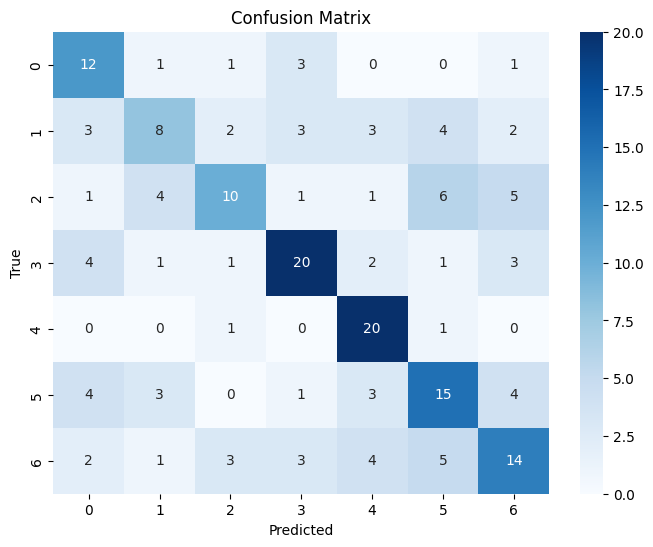


Classification Report:

              precision    recall  f1-score   support

           0       0.46      0.67      0.55        18
           1       0.44      0.32      0.37        25
           2       0.56      0.36      0.43        28
           3       0.65      0.62      0.63        32
           4       0.61      0.91      0.73        22
           5       0.47      0.50      0.48        30
           6       0.48      0.44      0.46        32

    accuracy                           0.53       187
   macro avg       0.52      0.55      0.52       187
weighted avg       0.53      0.53      0.52       187



In [19]:
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report:\n")
print(classification_report(labels, preds))


In [20]:
model.load_state_dict(torch.load("best_lstm.pth", map_location=device))
model.eval()


MotionLSTM(
  (chan_att): ChannelAttention(
    (fc): Sequential(
      (0): Linear(in_features=531, out_features=66, bias=True)
      (1): ReLU()
      (2): Linear(in_features=66, out_features=531, bias=True)
      (3): Sigmoid()
    )
  )
  (lstm): LSTM(531, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (temp_att): TemporalAttention(
    (fc): Linear(in_features=512, out_features=1, bias=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=7, bias=True)
  )
)

Evaluation on Validation Set

In [21]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for xb, yb in val_dl:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())


Classification Report

In [22]:
from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, digits=4))


              precision    recall  f1-score   support

           0     0.5455    0.6667    0.6000        18
           1     0.6111    0.4400    0.5116        25
           2     0.5385    0.5000    0.5185        28
           3     0.6207    0.5625    0.5902        32
           4     0.7692    0.9091    0.8333        22
           5     0.5357    0.5000    0.5172        30
           6     0.3947    0.4688    0.4286        32

    accuracy                         0.5615       187
   macro avg     0.5736    0.5781    0.5714       187
weighted avg     0.5650    0.5615    0.5591       187



Overall Accuracy

In [23]:
acc = (np.array(all_labels) == np.array(all_preds)).mean()
print("Final Validation Accuracy:", acc)


Final Validation Accuracy: 0.5614973262032086


Per-Class Accuracy

In [24]:
import numpy as np

labels = np.array(all_labels)
preds = np.array(all_preds)

unique_classes = np.unique(labels)

for cl in unique_classes:
    idx = labels == cl
    class_acc = (labels[idx] == preds[idx]).mean()
    print(f"Class {cl}: Accuracy = {class_acc:.3f}")


Class 0: Accuracy = 0.667
Class 1: Accuracy = 0.440
Class 2: Accuracy = 0.500
Class 3: Accuracy = 0.562
Class 4: Accuracy = 0.909
Class 5: Accuracy = 0.500
Class 6: Accuracy = 0.469


Probability Inspection for Debugging


This helps to check if the model is:

Overconfident

Always predicting one label

Producing uniform probabilities

In [25]:
softmax = nn.Softmax(dim=1)

model.eval()
with torch.no_grad():
    xb, yb = next(iter(val_dl))
    xb = xb.to(device)
    probs = softmax(model(xb)).cpu().numpy()

print("Probabilities for first batch sample:")
print(probs[0])


Probabilities for first batch sample:
[0.10866857 0.05792082 0.19347529 0.38615894 0.03793541 0.13017681
 0.08566413]


In [26]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.to(device)
        logits = model(xb)
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(yb.numpy())


Final Validation Accuracy

In [27]:
import numpy as np
final_acc = (np.array(all_preds) == np.array(all_labels)).mean()
print("Final Validation Accuracy:", final_acc)


Final Validation Accuracy: 0.5614973262032086


In [28]:
idx = 0  # choose any index from validation set
x = X_val[idx]  # numpy array
y_true = y_val[idx]

x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(0).to(device)  # (1,T,F)

model.eval()
with torch.no_grad():
    logits = model(x_tensor)
    pred = torch.argmax(logits, dim=1).item()

print("True Label:", y_true)
print("Predicted Label:", pred)


True Label: 5
Predicted Label: 3
